In [ ]:
pip install datashader

In [2]:
pip install geopandas

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import datashader as ds

In [4]:
import math

def friction(parameter,dis):
    frict=math.exp(parameter*dis)
    return frict

In [5]:
n = int(11)
N = n*n

In [6]:
distance = np.full((N, N), 1.0)

In [7]:
xcoord = np.array([])
ycoord = np.array([])

In [8]:
n = n + 1

for y in range(1, n):
    for x in range(1, n):
        xcoord = np.append(xcoord, [x]) 
        ycoord = np.append(ycoord, [y])

In [9]:
ij = 0
for i in range (0, N):
    xi = xcoord[i]
    yi = ycoord[i]
    for j in range (0,N):
        ij = ij+1
        xj = xcoord[j]
        yj = ycoord[j]
        dis = math.sqrt((((xi-xj)**2)+((yi-yj)**2)))
        distance[i][j] = dis
        if distance[i][j]==0:
            distance[i][j] = 0.5

In [10]:
tobs = np.full((N,N), 1.0)
origins = np.full((N), 1.0)
destinations = np.full((N), 1.0)
differences = np.full((N), 1.0)

In [11]:
from numpy import random

for i in range (0, N):
    for j in range (0, N):
        tobs[i][j]=1.0/(distance[i][j]*(0.1+random.rand()))

Tobs = np.sum(tobs)
for i in range (0, N):
    for j in range(0, N):
        ij=ij+1
        tobs[i,j]=1000*(tobs[i][j]/Tobs)

In [12]:
origins = np.sum(tobs, axis = 1)
destinations = np.sum(tobs, axis = 0)

In [13]:
To = np.sum(origins) 
Td = np.sum(destinations)
Tobs = np.sum(tobs)

In [14]:
beta = float(1.25)

In [15]:
trips = np.full((N, N), 1.0)
OPred = np.full((N), 1.0)
DPred = np.full((N), 1.0)
trips1 = np.full((N, N), 1.0)
tobs1 = np.full((N, N), 1.0)

In [16]:
total = 1000

for i in range(0, N):
    for j in range(0, N):
        trips[i][j]=origins[i]*destinations[j]/(friction(beta, distance[i][j]))

Ttrip = np.sum(trips)
for i in range(0, N):
    for j in range(0, N):
        trips[i][j]=total*((origins[i]*destinations[j])/(friction(beta, distance[i][j])))/Ttrip 

In [17]:
OPred = np.sum(trips, axis = 1)
DPred = np.sum(trips, axis = 0)

In [18]:
edges = pd.DataFrame(trips).reset_index().melt(id_vars = "index", 
                                               var_name = "target", 
                                               value_name = "weight").rename(columns={'index': "focal"})

In [19]:
edges['focal'] = edges['focal'].astype('int64')
edges['target'] = edges['target'].astype('int64')

In [20]:
nodes = pd.DataFrame({'index': np.arange(0, 121),
                      'X': xcoord,
                      'Y': ycoord}).set_index('index')

In [21]:
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image

from colorcet import palette
from matplotlib import cm

In [22]:
G = hammer_bundle(nodes, edges,
                  source='focal', target='target',
                  decay=0.25,
                  initial_bandwidth=0.1,
                  x='X', y='Y')

In [23]:
pal = pd.read_csv("https://raw.githubusercontent.com/asrenninger/palettes/master/scico_wide.csv")
pal = pal['hawaii']

pal = list(pal)

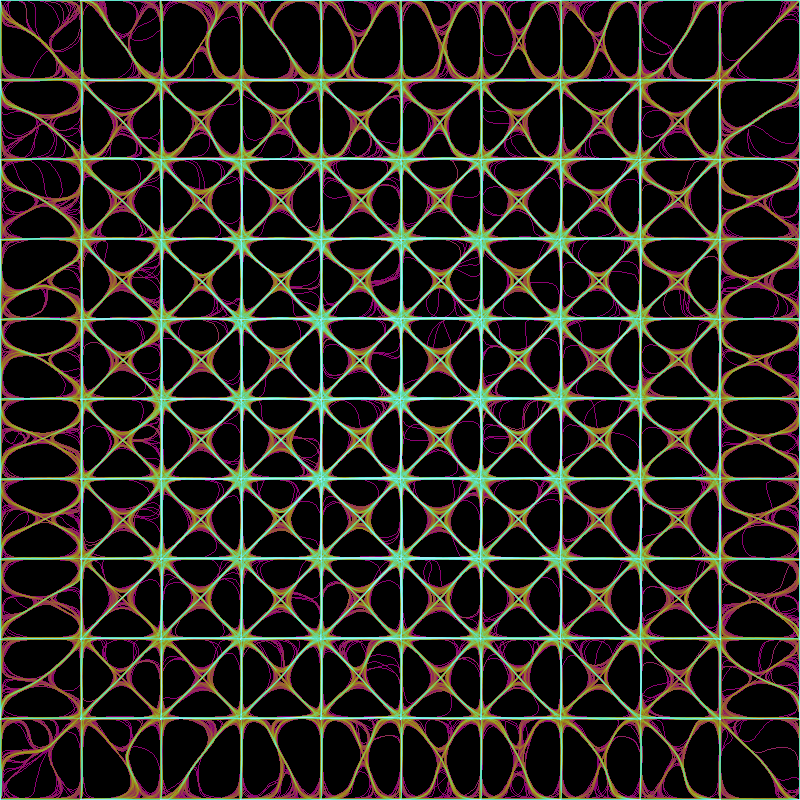

In [24]:
canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                   y_range=(nodes['Y'].min(), nodes['Y'].max()),
                   plot_height=800, plot_width=800)

tf.set_background(tf.shade(canvas.line(G, 'X','Y', agg=ds.count()), cmap=pal, name="Bundled"), '#000000')